# Sentiment Analysis with Deep Learning using BERT

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### install packages

In [4]:
!pip install transformers

     |████████████████████████████████| 675kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 17.5MB/s 
     |████████████████████████████████| 3.8MB 21.4MB/s 
     |████████████████████████████████| 890kB 39.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=088dcf8c08650815f48bff1cbd34ac0434a2996a49ada73cd6c369a960cd1190
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
!git clone https://github.com/NVIDIA/apex

Cloning into 'apex'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 7293 (delta 20), reused 19 (delta 6), pack-reused 7255
Receiving objects: 100% (7293/7293), 13.87 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (4920/4920), done.


In [6]:
cd apex

/content/apex


In [7]:
! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-ztca9g7u
Created temporary directory: /tmp/pip-req-tracker-nz7ody2b
Created requirements tracker '/tmp/pip-req-tracker-nz7ody2b'
Created temporary directory: /tmp/pip-install-7xo56pc4
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-7u8dzzsn
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-nz7ody2b'
    Running setup.py (path:/tmp/pip-req-build-7u8dzzsn/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.5.1+cu101


    running egg_info
    creating /tmp/pip-req-build-7u8dzzsn/pip-egg-info/apex.egg-info
    writing /tmp/pip-req-build-7u8dzzsn/pip-egg-info/apex.egg-info/PK

In [1]:
import torch
import torch.nn as nn
import random
import time
import math

import pandas as pd
import numpy as np
import collections
from collections import Counter

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import f1_score

from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.optim import Optimizer
import torch.nn.functional as F

from apex.fp16_utils import *
from apex import amp, optimizers
from apex.multi_tensor_apply import multi_tensor_applier

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


print(f'random seeds initialized, working on {device}')

random seeds initialized, working on cuda


In [3]:
#getting the clinical biobert tokenizer
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [4]:
#loads result dataframe or initializes an empty one
try:
  results_df = pd.read_csv('/content/drive/My Drive/ML_data/results.csv', index_col = 0)
except:
  results_df = pd.DataFrame(columns = ['experiment description', 'num samples', 'weighting', 'f1w', 'acc', 'auroc', 'ppv', 'sens', 'batch size'])

results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,tiny test dataset,1000,NaN,0.831008,0.885000,0.558339,0.000000,NaN,32
1,"larger test dataset, only subj notes",10000,NaN,0.854283,0.899500,0.780036,0.010000,0.400000,32
2,"larger test dataset, only subj notes",50000,NaN,0.876438,0.896900,0.795039,0.178138,0.445570,32
3,"larger test dataset, only subj notes",100000,NaN,0.876970,0.901000,0.807763,0.155172,0.493548,32
4,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.895400,0.798594,0.237219,0.436090,16
5,"weighted loss, both nlp fields",50000,"{'discharge': 8, 'admit': 1}",0.865623,0.901200,0.808986,0.070281,0.530303,16
6,"first try lamb, both nlp fields",10000,NaN,0.876643,0.895000,0.788044,0.200000,0.444444,16
7,"mixed prec, adults only, lamb",100000,NaN,0.877511,0.890000,0.824240,0.276190,0.460317,32
8,"mixed prec, bch only, lamb",102128,NaN,0.885827,0.900519,0.802072,0.233230,0.452906,64
9,"mixed prec, bch only, lamb",50000,NaN,0.859869,0.905000,0.500000,0.000000,NaN,16


In [5]:
#if there are holes in the index, clean with this cell

results_df.index = list(range(len(results_df)))
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,tiny test dataset,1000,NaN,0.831008,0.885000,0.558339,0.000000,NaN,32
1,"larger test dataset, only subj notes",10000,NaN,0.854283,0.899500,0.780036,0.010000,0.400000,32
2,"larger test dataset, only subj notes",50000,NaN,0.876438,0.896900,0.795039,0.178138,0.445570,32
3,"larger test dataset, only subj notes",100000,NaN,0.876970,0.901000,0.807763,0.155172,0.493548,32
4,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.895400,0.798594,0.237219,0.436090,16
5,"weighted loss, both nlp fields",50000,"{'discharge': 8, 'admit': 1}",0.865623,0.901200,0.808986,0.070281,0.530303,16
6,"first try lamb, both nlp fields",10000,NaN,0.876643,0.895000,0.788044,0.200000,0.444444,16
7,"mixed prec, adults only, lamb",100000,NaN,0.877511,0.890000,0.824240,0.276190,0.460317,32
8,"mixed prec, bch only, lamb",102128,NaN,0.885827,0.900519,0.802072,0.233230,0.452906,64
9,"mixed prec, bch only, lamb",50000,NaN,0.859869,0.905000,0.500000,0.000000,NaN,16


### define helper functions

In [6]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return sklearn.metrics.accuracy_score(labels_flat, preds_flat)
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [7]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [8]:
def train_model(model, dataloader_train, dataloader_valid, save_name, optim = 'default', TPU = False, lr = 1e-5, eps = 1e-8, epochs = 3, weights = None):
  
  #model.to(device)
  
  if weights:
    weight = torch.tensor([float(i) for i in weights.values()]).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight = weight)
    print ('using weighted cross entropy loss')
    print (loss_fn)

  if optim == 'default':
    print ('optimizing with AdamW')
    optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
  else:
    print ('optimizing with ', str(optim))
    optimizer = optim

  model, optimizer = amp.initialize(model.to(device), optimizer)

  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)
  
  for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        if weights:
          loss = loss_fn(outputs[1], batch[2])
        else:
          loss = outputs[0]

        loss_train_total += loss.item()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
          scaled_loss.backward()
        #loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        if TPU:
          xm.optimizer_step(optimizer, barrier=True)
        else: 
          optimizer.step()

        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/{save_name}_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = accuracy_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Validation accuracy: {val_acc}')


In [9]:
def get_metrics(dataloader): #(predictions, true_vals, dataloader):

  _, predictions, true_vals = evaluate(dataloader)

  preds = [np.argmax(pred) for pred in predictions]
  preds_flat = np.argmax(preds).flatten()
  true_vals = true_vals.flatten()

  f1_w = sklearn.metrics.f1_score(true_vals, preds, average='weighted')
  f1 = sklearn.metrics.f1_score(true_vals, preds, average=None)
  acc = sklearn.metrics.accuracy_score(true_vals, preds)
  prec = sklearn.metrics.precision_score(true_vals,preds, average=None) 
  rec = sklearn.metrics.recall_score(true_vals,preds, average=None)
  auroc = sklearn.metrics.roc_auc_score(true_vals,predictions[:,1], average=None)
  confusion = sklearn.metrics.confusion_matrix(true_vals, preds)

  tn, fn, fp, tp = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]

  sens = tp/(tp + fn)
  spec = tn/(tn + fp)
  ppv = tp/(tp + fp)
  npv = tn/(tn + fn)

  print ('Metrics Report:')
  print ('---------------')
  print ('weighted f1: ', f1_w)
  print ('AUROC:       ',auroc)
  print ('accuracy:    ', acc)
  print ('precision:   ', prec)
  print ('recall:      ', rec)
  print ('sensitivity: ', sens)
  print ('specificity: ', spec)
  print ('PPV:         ', ppv)
  print ('NPV:         ', npv)
  print ()
  print ('confusion matrix')
  print (confusion)

  results_df.loc[len(results_df)] = [desc,num_samples, weights, f1_w, acc, auroc, ppv, sens, batch_size]

In [10]:
def encode_data(text_field):
  encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'][text_field].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
    )

  encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'][text_field].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
    )


  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(df[df.data_type=='train'].label.values)

  input_ids_val = encoded_data_val['input_ids']
  attention_masks_val = encoded_data_val['attention_mask']
  labels_val = torch.tensor(df[df.data_type=='val'].label.values)

  return input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val



def create_dataloaders(batch_size = 32):
  dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

  dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

  dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
  
  return dataloader_train, dataloader_validation

In [11]:
class Lamb(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6,
                 weight_decay=0.01, adam=False):   # I changed wd default from 0
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        self.adam = adam
        super(Lamb, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Lamb does not support sparse gradients, consider SparseAdam instad.')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Paper v3 does not use debiasing.
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                # Apply bias to lr to avoid broadcast.
                step_size = group['lr']  * math.sqrt(bias_correction2) / bias_correction1

                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)

                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(group['weight_decay'], p.data)

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio
                if self.adam:
                    trust_ratio = 1

                p.data.add_(-step_size * trust_ratio, adam_step)

        return loss

from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss    

def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

# import the master dataframe

In [12]:
data = pd.read_csv  ('/content/drive/My Drive/ML_data/complete_clean_combo_data.csv', index_col = None, low_memory = False)

# First pass - non processed subjective notes

In [ ]:
weights = None
num_samples = 100000
desc = 'larger test dataset, only subj notes'

### Data importing and Preprocessing

In [ ]:
df = data.sample(num_samples)

In [ ]:
#using discharge column to get labels
df.discharge.value_counts()

discharge    90136
admit         9864
Name: discharge, dtype: int64

In [ ]:
label_dict = {'admit':1, 'discharge':0}
df['label'] = df.discharge.replace(label_dict)

In [ ]:
df = df[['CleanSubjectiveNotes', 'discharge', 'label']]

In [ ]:
df.head()

,CleanSubjectiveNotes,discharge,label
78145,as per son's translation. patient got up from ...,discharge,0
138434,complains of lower back pain down to hip and r...,discharge,0
106143,patient brought by mother with shortness of br...,discharge,0
116801,patient complains of vomiting x2 days. denies ...,admit,1
133861,states has lower back pain for a week and lowe...,discharge,0


### creating train and valid dataloaders

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['discharge', 'label', 'data_type']).count()

CleanSubjectiveNotes
discharge label data_type                      
admit     1     train                      8878
                val                         986
discharge 0     train                     81122
                val                        9014

In [ ]:
#encoding using bert tokenizer
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('CleanSubjectiveNotes')

In [ ]:
dataloader_train, dataloader_validation = create_dataloaders()

### training

In [ ]:
#instantiate bert model

model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation)


Epoch 1
Training loss: 0.28150320104881194
Validation loss: 0.26354485255079907
F1 Score (Weighted): 0.8647319631009545



Epoch 2
Training loss: 0.25216405331383934
Validation loss: 0.27502434269879195
F1 Score (Weighted): 0.8703839880229233



Epoch 3
Training loss: 0.23051603078654112
Validation loss: 0.2743735836622433
F1 Score (Weighted): 0.8769695846402432



In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8769695846402432
AUROC:        0.8077633125122922
accuracy:     0.901
precision:    [0.91403509 0.49354839]
recall:       [0.98258265 0.15517241]
sensitivity:  0.4935483870967742
specificity:  0.9140350877192982
PPV:          0.15517241379310345
NPV:          0.9825826492123364

confusion matrix
[[8857  157]
 [ 833  153]]


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens
0,tiny test dataset,1000,None,0.831008,0.8850,0.558339,0.000000,NaN
1,tiny test dataset,1000,None,0.831008,0.8850,0.558339,0.000000,NaN
2,tiny test dataset,1000,None,0.831008,0.8850,0.558339,0.000000,NaN
3,"larger test dataset, only subj notes",10000,None,0.854283,0.8995,0.780036,0.010000,0.400000
4,"larger test dataset, only subj notes",50000,None,0.876438,0.8969,0.795039,0.178138,0.445570
5,"larger test dataset, only subj notes",100000,None,0.876970,0.9010,0.807763,0.155172,0.493548


so let's say that 50000 examples is reflective and now do some experimentation on that

# second pass - adding medical history

In [ ]:
weights = None
num_samples = 50000
desc = 'subj notes and pmhx'

### Data loading and Preprocessing

In [ ]:
df = data.sample(50000)

In [ ]:
df.shape

(50000, 122)

In [ ]:
df.discharge.value_counts()

discharge    45112
admit         4888
Name: discharge, dtype: int64

In [ ]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [ ]:
df['label'] = df.discharge.replace(label_dict)

In [ ]:
df = df[['CleanSubjectiveNotes', 'pmhx','discharge', 'label']]

In [ ]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [ ]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
144699,discharge,0,"lower back pain, abdominal pain, epigastric pa..."
142547,discharge,0,"cold s+s x1mth, patient complains of sinus pai..."
142960,discharge,0,patient reported was elbowed to upper left sid...
116701,discharge,0,with complains of left sided lower abdominal p...
27916,discharge,0,per patient is 7-8 weeks pregnant. last menstr...


## Training/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.2, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type       
admit     1     train       3910
                val          978
discharge 0     train      36090
                val         9022

## Loading Tokenizer and Encoding our Data

In [ ]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [ ]:
dataloader_train, dataloader_validation = create_dataloaders(16)

In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation)


Epoch 1
Training loss: 0.28256826400309804
Validation loss: 0.26461688067913053
F1 Score (Weighted): 0.8734886372237314



Epoch 2
Training loss: 0.2501123862288892
Validation loss: 0.2682400894701481
F1 Score (Weighted): 0.879665592679998



Epoch 3
Training loss: 0.22407042768597601
Validation loss: 0.2902081708073616
F1 Score (Weighted): 0.8812139862965125



In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8812139862965125
AUROC:        0.7985938938627187
accuracy:     0.8954
precision:    [0.92120828 0.43609023]
recall:       [0.96674795 0.23721881]
sensitivity:  0.43609022556390975
specificity:  0.9212082805238698
PPV:          0.23721881390593047
NPV:          0.9667479494568831

confusion matrix
[[8722  300]
 [ 746  232]]


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens
0,tiny test dataset,1000,None,0.831008,0.8850,0.558339,0.000000,NaN
1,tiny test dataset,1000,None,0.831008,0.8850,0.558339,0.000000,NaN
2,tiny test dataset,1000,None,0.831008,0.8850,0.558339,0.000000,NaN
3,"larger test dataset, only subj notes",10000,None,0.854283,0.8995,0.780036,0.010000,0.400000
4,"larger test dataset, only subj notes",50000,None,0.876438,0.8969,0.795039,0.178138,0.445570
5,"larger test dataset, only subj notes",100000,None,0.876970,0.9010,0.807763,0.155172,0.493548
6,"larger test dataset, only subj notes",100000,None,0.881214,0.8954,0.798594,0.237219,0.436090


In [ ]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

# third pass - weighted loss function

In [ ]:
weights = torch.tensor([1.,8.]).to(device)
num_samples = 50000
desc = 'weighted loss, both nlp fields'

### Exploratory Data Analysis and Preprocessing

In [ ]:
df = data.sample(num_samples)

In [ ]:
df.discharge.value_counts()

discharge    45025
admit         4975
Name: discharge, dtype: int64

In [ ]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [ ]:
df['label'] = df.discharge.replace(label_dict)

In [ ]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [ ]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
102395,discharge,0,rectal bleeding x 4 days. bowel movement x 5 t...
112374,discharge,0,unable to void x 4hours and with lower abdo pa...
111136,discharge,0,"right lower leg pain,calf pain and knee pain f..."
140645,discharge,0,states felt itchy in the left eye this afterno...
117690,discharge,0,mom states that patient started summer camp on...


## Training/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type       
admit     1     train       4477
                val          498
discharge 0     train      40523
                val         4502

## Loading Tokenizer and Encoding our Data

In [ ]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [ ]:
dataloader_train, dataloader_validation = create_dataloaders(16)

In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation, 'weighted_1')

FileNotFoundError: ignored

In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
val_acc = accuracy_score_func(predictions, true_vals)

In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8656233384142217
AUROC:        0.808985832267319
accuracy:     0.9012
precision:    [0.90616133 0.53030303]
recall:       [0.99311417 0.07028112]
sensitivity:  0.5303030303030303
specificity:  0.9061613295500608
PPV:          0.07028112449799197
NPV:          0.9931141714793426

confusion matrix
[[4471   31]
 [ 463   35]]


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens
0,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
1,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548
6,"larger test dataset, only subj notes",100000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090
7,"weighted loss, both nlp fields",50000,"[tensor(1., device='cuda:0'), tensor(8., devic...",0.865623,0.9012,0.808986,0.070281,0.530303


In [ ]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

# 4th pass - lamb optimizer

In [ ]:
weights = None
num_samples = 10000
desc = 'first try lamb optimizer, all nlp'

### Exploratory Data Analysis and Preprocessing

In [ ]:
df = data.sample(num_samples)

In [ ]:
df.discharge.value_counts()

discharge    9000
admit        1000
Name: discharge, dtype: int64

In [ ]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [ ]:
df['label'] = df.discharge.replace(label_dict)

In [ ]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [ ]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
102395,discharge,0,rectal bleeding x 4 days. bowel movement x 5 t...
112374,discharge,0,unable to void x 4hours and with lower abdo pa...
111136,discharge,0,"right lower leg pain,calf pain and knee pain f..."
140645,discharge,0,states felt itchy in the left eye this afterno...
117690,discharge,0,mom states that patient started summer camp on...


## Training/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type      
admit     1     train       900
                val         100
discharge 0     train      8100
                val         900

## Loading Tokenizer and Encoding our Data

In [ ]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [ ]:
dataloader_train, dataloader_validation = create_dataloaders(16)

In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
opt = Lamb(model.parameters())

In [ ]:
train_model(model, dataloader_train, dataloader_validation,   'weighted_1', optim = opt,)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)



Epoch 1
Training loss: 0.3105667379368791
Validation loss: 0.30804725227847934
F1 Score (Weighted): 0.8616509264377858
Validation accuracy: 0.885



Epoch 2
Training loss: 0.27689986457621435
Validation loss: 0.3315040984797099
F1 Score (Weighted): 0.8726093069743017
Validation accuracy: 0.9



Epoch 3
Training loss: 0.22345271680775375
Validation loss: 0.31287631747268496
F1 Score (Weighted): 0.8766428106701367
Validation accuracy: 0.895



In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
val_acc = accuracy_score_func(predictions, true_vals)

In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8766428106701367
AUROC:        0.7880444444444443
accuracy:     0.895
precision:    [0.91623037 0.44444444]
recall:       [0.97222222 0.2       ]
sensitivity:  0.4444444444444444
specificity:  0.9162303664921466
PPV:          0.2
NPV:          0.9722222222222222

confusion matrix
[[875  25]
 [ 80  20]]


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens
0,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
1,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548
6,"larger test dataset, only subj notes",100000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090
7,"weighted loss, both nlp fields",50000,"tensor([1., 8.], device='cuda:0')",0.865623,0.9012,0.808986,0.070281,0.530303
8,"first try lamb optimizer, all nlp",10000,None,0.876643,0.8950,0.788044,0.200000,0.444444


In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation,   'weighted_1')


Epoch 1
Training loss: 0.31046631010530473
Validation loss: 0.30094566621950697
F1 Score (Weighted): 0.8582978723404255
Validation accuracy: 0.892



Epoch 2
Training loss: 0.27486811136267747
Validation loss: 0.2946878812970623
F1 Score (Weighted): 0.8674454956807898
Validation accuracy: 0.894



Epoch 3
Training loss: 0.24444527987582645
Validation loss: 0.3002486279204724
F1 Score (Weighted): 0.8686263058854066
Validation accuracy: 0.894



In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
val_acc = accuracy_score_func(predictions, true_vals)

In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8686263058854066
AUROC:        0.7688111111111111
accuracy:     0.894
precision:    [0.91012397 0.40625   ]
recall:       [0.97888889 0.13      ]
sensitivity:  0.40625
specificity:  0.9101239669421488
PPV:          0.13
NPV:          0.9788888888888889

confusion matrix
[[881  19]
 [ 87  13]]


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens
0,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
1,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548
6,"larger test dataset, only subj notes",100000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090
7,"weighted loss, both nlp fields",50000,"tensor([1., 8.], device='cuda:0')",0.865623,0.9012,0.808986,0.070281,0.530303
8,"first try lamb optimizer, all nlp",10000,None,0.876643,0.8950,0.788044,0.200000,0.444444
9,"first try lamb optimizer, all nlp",10000,None,0.868626,0.8940,0.768811,0.130000,0.406250


In [ ]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

# code below is for reloading models to use for inference

In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device);

In [ ]:
model.load_state_dict(torch.load('Models/<<INSERT MODEL NAME HERE>>.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 163/171

Class: not-relevant
Accuracy: 20/32

Class: angry
Accuracy: 7/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 4/5

Class: surprise
Accuracy: 2/5



# Have done a lot of refactoring so want to make sure everything works



##First pass - non processed subjective notes

In [ ]:
weights = None
num_samples = 250
desc = 'retry basic model'
batch_size = 32

### Data importing and Preprocessing

In [ ]:
df = data.sample(num_samples)

In [ ]:
#using discharge column to get labels
df.discharge.value_counts()

discharge    230
admit         20
Name: discharge, dtype: int64

In [ ]:
label_dict = {'admit':1, 'discharge':0}
df['label'] = df.discharge.replace(label_dict)

In [ ]:
df = df[['CleanSubjectiveNotes', 'discharge', 'label']]

In [ ]:
df.head()

,CleanSubjectiveNotes,discharge,label
74047,complains of constant dizziness and generalize...,discharge,0
136461,patient at school yesterday and was pushed by ...,discharge,0
151787,"complains of bodyache , sore throat,painful sw...",discharge,0
69220,sudden onset of dizziness while at work. no pr...,discharge,0
73830,patient has been unwell since last week with f...,discharge,0


### creating train and valid dataloaders

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['discharge', 'label', 'data_type']).count()

CleanSubjectiveNotes
discharge label data_type                      
admit     1     train                        18
                val                           2
discharge 0     train                       207
                val                          23

In [ ]:
#encoding using bert tokenizer
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('CleanSubjectiveNotes')

In [ ]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

### training

In [ ]:
#instantiate bert model

model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation, 'redo1')


Epoch 1
Training loss: 0.5714132823050022
Validation loss: 0.45234110951423645
F1 Score (Weighted): 0.8816666666666667
Validation accuracy: 0.92



Epoch 2
Training loss: 0.40213580802083015
Validation loss: 0.37709400057792664
F1 Score (Weighted): 0.8816666666666667
Validation accuracy: 0.92



Epoch 3
Training loss: 0.359084565192461
Validation loss: 0.3558696508407593
F1 Score (Weighted): 0.8816666666666667
Validation accuracy: 0.92



In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8816666666666667
AUROC:        0.6086956521739131
accuracy:     0.92
precision:    [0.92 0.  ]
recall:       [1. 0.]
sensitivity:  nan
specificity:  0.92
PPV:          0.0
NPV:          1.0

confusion matrix
[[23  0]
 [ 2  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN,32
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000,32
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570,32
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548,32
6,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090,16
7,retry basic model,250,None,0.881667,0.9200,0.608696,0.000000,NaN,32
8,"first try lamb, both nlp fields",10000,NaN,0.876643,0.8950,0.788044,0.200000,0.444444,16


## second pass - adding medical history

In [ ]:
weights = None
num_samples = 250
desc = 'subj notes and pmhx'
batch_size = 32

### Data loading and Preprocessing

In [ ]:
df = data.sample(num_samples)

In [ ]:
df.shape

(250, 122)

In [ ]:
df.discharge.value_counts()

discharge    224
admit         26
Name: discharge, dtype: int64

In [ ]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [ ]:
df['label'] = df.discharge.replace(label_dict)

In [ ]:
df = df[['CleanSubjectiveNotes', 'pmhx','discharge', 'label']]

In [ ]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [ ]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
78145,discharge,0,as per son's translation. patient got up from ...
138434,discharge,0,complains of lower back pain down to hip and r...
106143,discharge,0,patient brought by mother with shortness of br...
116801,admit,1,patient complains of vomiting x2 days. denies ...
133861,discharge,0,states has lower back pain for a week and lowe...


### Training/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.2, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type      
admit     1     train        21
                val           5
discharge 0     train       179
                val          45

### Loading Tokenizer and Encoding our Data

In [ ]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [ ]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation, 'redo2')


Epoch 1
Training loss: 0.4141485605921064
Validation loss: 0.3324115425348282
F1 Score (Weighted): 0.8526315789473685
Validation accuracy: 0.9



Epoch 2
Training loss: 0.32568989055497305
Validation loss: 0.3245757222175598
F1 Score (Weighted): 0.8526315789473685
Validation accuracy: 0.9



Epoch 3
Training loss: 0.308699264058045
Validation loss: 0.3209809958934784
F1 Score (Weighted): 0.8526315789473685
Validation accuracy: 0.9



In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8526315789473685
AUROC:        0.7733333333333334
accuracy:     0.9
precision:    [0.9 0. ]
recall:       [1. 0.]
sensitivity:  nan
specificity:  0.9
PPV:          0.0
NPV:          1.0

confusion matrix
[[45  0]
 [ 5  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN,32
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000,32
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570,32
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548,32
6,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090,16
7,subj notes and pmhx,250,None,0.852632,0.9000,0.773333,0.000000,NaN,32
8,"first try lamb, both nlp fields",10000,NaN,0.876643,0.8950,0.788044,0.200000,0.444444,16


In [ ]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

## third pass - weighted loss function

In [ ]:
weights = {'discharge':7, 'admit':1}
num_samples = 250
desc = 'weighted loss, both nlp fields'
batch_size = 32

### Exploratory Data Analysis and Preprocessing

In [ ]:
df = data.sample(num_samples)

In [ ]:
df.discharge.value_counts()

discharge    219
admit         31
Name: discharge, dtype: int64

In [ ]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [ ]:
df['label'] = df.discharge.replace(label_dict)

In [ ]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [ ]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
102395,discharge,0,rectal bleeding x 4 days. bowel movement x 5 t...
112374,discharge,0,unable to void x 4hours and with lower abdo pa...
111136,discharge,0,"right lower leg pain,calf pain and knee pain f..."
140645,discharge,0,states felt itchy in the left eye this afterno...
117690,discharge,0,mom states that patient started summer camp on...


### Training/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type      
admit     1     train        28
                val           3
discharge 0     train       197
                val          22

### Loading Tokenizer and Encoding our Data

In [ ]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [ ]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation, 'redo_weighted_1', weights = weights)


Epoch 1
Training loss: 0.42185987159609795
Validation loss: 0.4131432771682739
F1 Score (Weighted): 0.8238297872340425
Validation accuracy: 0.88



Epoch 2
Training loss: 0.27917953580617905
Validation loss: 0.38427790999412537
F1 Score (Weighted): 0.8238297872340425
Validation accuracy: 0.88



Epoch 3
Training loss: 0.2324636373668909
Validation loss: 0.37664520740509033
F1 Score (Weighted): 0.8238297872340425
Validation accuracy: 0.88



In [ ]:
get_metrics(dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8238297872340425
AUROC:        0.5303030303030303
accuracy:     0.88
precision:    [0.88 0.  ]
recall:       [1. 0.]
sensitivity:  nan
specificity:  0.88
PPV:          0.0
NPV:          1.0

confusion matrix
[[22  0]
 [ 3  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN,32
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000,32
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570,32
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548,32
6,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090,16
7,"weighted loss, both nlp fields",250,"{'discharge': 7, 'admit': 1}",0.823830,0.8800,0.530303,0.000000,NaN,32
8,"first try lamb, both nlp fields",10000,NaN,0.876643,0.8950,0.788044,0.200000,0.444444,16


In [ ]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

## 4th pass - lamb optimizer

In [15]:
#import collections
import math

#import torch
#from tensorboardX import SummaryWriter
from torch.optim import Optimizer


#def log_lamb_rs(optimizer: Optimizer, event_writer: SummaryWriter, token_count: int):
#    """Log a histogram of trust ratio scalars in across layers."""
#    results = collections.defaultdict(list)
#    for group in optimizer.param_groups:
#        for p in group['params']:
#            state = optimizer.state[p]
#            for i in ('weight_norm', 'adam_norm', 'trust_ratio'):
#                if i in state:
#                    results[i].append(state[i])

#  for k, v in results.items():
#        event_writer.add_histogram(f'lamb/{k}', torch.tensor(v), token_count)

class Lamb(Optimizer):
    r"""Implements Lamb algorithm.
    It has been proposed in `Large Batch Optimization for Deep Learning: Training BERT in 76 minutes`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        adam (bool, optional): always use trust ratio = 1, which turns this into
            Adam. Useful for comparison purposes.
    .. _Large Batch Optimization for Deep Learning: Training BERT in 76 minutes:
        https://arxiv.org/abs/1904.00962
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6,
                 weight_decay=0.01, adam=False):   #I changed weight decay from original which was 0
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        self.adam = adam
        super(Lamb, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Lamb does not support sparse gradients, consider SparseAdam instad.')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Paper v3 does not use debiasing.
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                # Apply bias to lr to avoid broadcast.
                step_size = group['lr']  * math.sqrt(bias_correction2) / bias_correction1

                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)

                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(group['weight_decay'], p.data)

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio
                if self.adam:
                    trust_ratio = 1

                p.data.add_(-step_size * trust_ratio, adam_step)

        return loss

In [16]:
weights = {'discharge': 7, 'admit': 1}
num_samples = 250
desc = ' lamb optimizer, weighted loss, all nlp'
batch_size = 16

### Exploratory Data Analysis and Preprocessing

In [17]:
df = data.sample(num_samples)

In [18]:
df.discharge.value_counts()

discharge    219
admit         31
Name: discharge, dtype: int64

In [19]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [20]:
df['label'] = df.discharge.replace(label_dict)

In [21]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [22]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
102395,discharge,0,rectal bleeding x 4 days. bowel movement x 5 t...
112374,discharge,0,unable to void x 4hours and with lower abdo pa...
111136,discharge,0,"right lower leg pain,calf pain and knee pain f..."
140645,discharge,0,states felt itchy in the left eye this afterno...
117690,discharge,0,mom states that patient started summer camp on...


### Training/Validation Split

In [23]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [24]:
df['data_type'] = ['not_set']*df.shape[0]

In [25]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [26]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type      
admit     1     train        28
                val           3
discharge 0     train       197
                val          22

### Loading Tokenizer and Encoding our Data

In [27]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [28]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [29]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [30]:
opt = Lamb(model.parameters())

In [31]:
train_model(model, dataloader_train, dataloader_validation, 'redo_lamb', weights = weights, optim = opt)

using weighted cross entropy loss
CrossEntropyLoss()
optimizing with  Lamb (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.01
)


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)



Epoch 1
Training loss: 0.4448929230372111
Validation loss: 0.4736948013305664
F1 Score (Weighted): 0.8238297872340425
Validation accuracy: 0.88



Epoch 2
Training loss: 0.3536413510640462
Validation loss: 0.43218961358070374
F1 Score (Weighted): 0.8238297872340425
Validation accuracy: 0.88



Epoch 3
Training loss: 0.30061187744140627
Validation loss: 0.4261860251426697
F1 Score (Weighted): 0.8238297872340425
Validation accuracy: 0.88



In [32]:
get_metrics(dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8238297872340425
AUROC:        0.6212121212121212
accuracy:     0.88
precision:    [0.88 0.  ]
recall:       [1. 0.]
sensitivity:  nan
specificity:  0.88
PPV:          0.0
NPV:          1.0

confusion matrix
[[22  0]
 [ 3  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


In [33]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN,32
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000,32
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570,32
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548,32
6,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090,16
7,"lamb optimizer, weighted loss, all nlp",250,"{'discharge': 7, 'admit': 1}",0.823830,0.8800,0.621212,0.000000,NaN,16
8,"first try lamb, both nlp fields",10000,NaN,0.876643,0.8950,0.788044,0.200000,0.444444,16


## fifth pass - LAMB for real.  no class weights

In [38]:
weights = None
num_samples = 50000
desc = ' lamb optimizer,  all nlp'
batch_size = 16

### Exploratory Data Analysis and Preprocessing

In [39]:
df = data.sample(num_samples)

In [40]:
df.discharge.value_counts()

discharge    45039
admit         4961
Name: discharge, dtype: int64

In [41]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [42]:
df['label'] = df.discharge.replace(label_dict)

In [43]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [44]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
74047,discharge,0,complains of constant dizziness and generalize...
136461,discharge,0,patient at school yesterday and was pushed by ...
151787,discharge,0,"complains of bodyache , sore throat,painful sw..."
69220,discharge,0,sudden onset of dizziness while at work. no pr...
73830,discharge,0,patient has been unwell since last week with f...


### Training/Validation Split

In [45]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [46]:
df['data_type'] = ['not_set']*df.shape[0]

In [47]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [48]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type       
admit     1     train       4465
                val          496
discharge 0     train      40535
                val         4504

### Loading Tokenizer and Encoding our Data

In [49]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [50]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [51]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [52]:
opt = Lamb(model.parameters())

In [55]:
train_model(model, dataloader_train, dataloader_validation, 'large scale lamb', optim = opt)

optimizing with  Lamb (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-06
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0.01
)



Epoch 1
Training loss: 0.3114237447765547
Validation loss: 0.3236989986401396
F1 Score (Weighted): 0.8537885521885522
Validation accuracy: 0.9008



Epoch 2
Training loss: 0.3282168589047677
Validation loss: 0.32750142694186096
F1 Score (Weighted): 0.8537885521885522
Validation accuracy: 0.9008



Epoch 3
Training loss: 0.3263193460183342
Validation loss: 0.3246102753919534
F1 Score (Weighted): 0.8537885521885522
Validation accuracy: 0.9008



In [ ]:
get_metrics(dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8238297872340425
AUROC:        0.6212121212121212
accuracy:     0.88
precision:    [0.88 0.  ]
recall:       [1. 0.]
sensitivity:  nan
specificity:  0.88
PPV:          0.0
NPV:          1.0

confusion matrix
[[22  0]
 [ 3  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN,32
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000,32
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570,32
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548,32
6,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090,16
7,"lamb optimizer, weighted loss, all nlp",250,"{'discharge': 7, 'admit': 1}",0.823830,0.8800,0.621212,0.000000,NaN,16
8,"first try lamb, both nlp fields",10000,NaN,0.876643,0.8950,0.788044,0.200000,0.444444,16


In [ ]:
##

In [ ]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [ ]:
train_model(model, dataloader_train, dataloader_validation,   'weighted_1')


Epoch 1
Training loss: 0.31046631010530473
Validation loss: 0.30094566621950697
F1 Score (Weighted): 0.8582978723404255
Validation accuracy: 0.892



Epoch 2
Training loss: 0.27486811136267747
Validation loss: 0.2946878812970623
F1 Score (Weighted): 0.8674454956807898
Validation accuracy: 0.894



Epoch 3
Training loss: 0.24444527987582645
Validation loss: 0.3002486279204724
F1 Score (Weighted): 0.8686263058854066
Validation accuracy: 0.894



In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
val_acc = accuracy_score_func(predictions, true_vals)

In [ ]:
get_metrics(predictions, true_vals, dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8686263058854066
AUROC:        0.7688111111111111
accuracy:     0.894
precision:    [0.91012397 0.40625   ]
recall:       [0.97888889 0.13      ]
sensitivity:  0.40625
specificity:  0.9101239669421488
PPV:          0.13
NPV:          0.9788888888888889

confusion matrix
[[881  19]
 [ 87  13]]


In [ ]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens
0,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
1,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548
6,"larger test dataset, only subj notes",100000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090
7,"weighted loss, both nlp fields",50000,"tensor([1., 8.], device='cuda:0')",0.865623,0.9012,0.808986,0.070281,0.530303
8,"first try lamb optimizer, all nlp",10000,None,0.876643,0.8950,0.788044,0.200000,0.444444
9,"first try lamb optimizer, all nlp",10000,None,0.868626,0.8940,0.768811,0.130000,0.406250


In [ ]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

# trying mixed precision training

## pass 6 - first try

In [10]:
weights = None
num_samples = 50000
desc = ' lamb optimizer,  all nlp, mixed precision'
batch_size = 16

### Exploratory Data Analysis and Preprocessing

In [26]:
df = data.sample(num_samples)

In [27]:
df.discharge.value_counts()

discharge    45025
admit         4975
Name: discharge, dtype: int64

In [28]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [29]:
df['label'] = df.discharge.replace(label_dict)

In [30]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [31]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
102395,discharge,0,rectal bleeding x 4 days. bowel movement x 5 t...
112374,discharge,0,unable to void x 4hours and with lower abdo pa...
111136,discharge,0,"right lower leg pain,calf pain and knee pain f..."
140645,discharge,0,states felt itchy in the left eye this afterno...
117690,discharge,0,mom states that patient started summer camp on...


### Training/Validation Split

In [32]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [33]:
df['data_type'] = ['not_set']*df.shape[0]

In [34]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [35]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type       
admit     1     train       4477
                val          498
discharge 0     train      40523
                val         4502

### Loading Tokenizer and Encoding our Data

In [36]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [37]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [38]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [39]:
opt = Lamb(model.parameters())

In [41]:
from apex.fp16_utils import *
from apex import amp, optimizers
from apex.multi_tensor_apply import multi_tensor_applier

In [43]:
model, opt = amp.initialize(model.to(device), opt)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [45]:
train_model(model, dataloader_train, dataloader_validation, 'large scale lamb', optim = opt)

optimizing with  Lamb (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.01
)


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0

Epoch 1
Training loss: 0.2942846773812727
Validation loss: 0.28632936136315046
F1 Score (Weighted): 0.8668034558568288
Validation accuracy: 0.9012


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0

Epoch 2
Training loss: 0.26360791512535553
Validation loss: 0.2774037138198892
F1 Score (Weighted): 0.8762630754741786
Validation accuracy: 0.9002



Epoch 3
Training loss: 0.21948925289598556
Validation loss: 0.29282116767364186
F1 Score (Weighted): 0.8802921835100754
Validation accuracy: 0.895



In [46]:
get_metrics(dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8802921835100754
AUROC:        0.8038883655457013
accuracy:     0.895
precision:    [0.91995776 0.4490566 ]
recall:       [0.96756997 0.23895582]
sensitivity:  0.4490566037735849
specificity:  0.9199577613516368
PPV:          0.2389558232931727
NPV:          0.9675699689027099

confusion matrix
[[4356  146]
 [ 379  119]]


In [47]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
2,tiny test dataset,1000,NaN,0.831008,0.8850,0.558339,0.000000,NaN,32
3,"larger test dataset, only subj notes",10000,NaN,0.854283,0.8995,0.780036,0.010000,0.400000,32
4,"larger test dataset, only subj notes",50000,NaN,0.876438,0.8969,0.795039,0.178138,0.445570,32
5,"larger test dataset, only subj notes",100000,NaN,0.876970,0.9010,0.807763,0.155172,0.493548,32
6,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.8954,0.798594,0.237219,0.436090,16
7,"lamb optimizer, all nlp, mixed precision",50000,None,0.880292,0.8950,0.803888,0.238956,0.449057,16
8,"first try lamb, both nlp fields",10000,NaN,0.876643,0.8950,0.788044,0.200000,0.444444,16


In [ ]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

## pass 7 - mixed precision, adults only

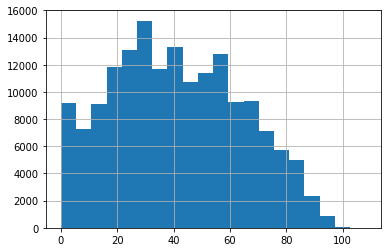

In [19]:
data.AgeNumber.hist(bins = 20)

In [20]:
data = data[data['AgeNumber'] >= 16]
len(data)

141561

In [21]:
weights = None
num_samples = 100000
desc = 'mixed prec, adults only, lamb'
batch_size = 32

### Exploratory Data Analysis and Preprocessing

In [22]:
df = data.sample(num_samples)

In [23]:
df.discharge.value_counts()

discharge    89503
admit        10497
Name: discharge, dtype: int64

In [24]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [25]:
df['label'] = df.discharge.replace(label_dict)

In [26]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [27]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
111097,discharge,0,"us done on left leg, no significant medical hi..."
74645,discharge,0,x8 weeks gestation. woke up at 0830-left .arm ...
82181,discharge,0,patient states no history of hypertension - to...
46685,discharge,0,"patient complains of frontal headache, general..."
51509,discharge,0,patient reports of temporal region headache th...


### Training/Validation Split

In [28]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [29]:
df['data_type'] = ['not_set']*df.shape[0]

In [30]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [31]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type       
admit     1     train       9447
                val         1050
discharge 0     train      80553
                val         8950

### Loading Tokenizer and Encoding our Data

In [32]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [33]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [34]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [35]:
opt = Lamb(model.parameters())

In [113]:
#model, opt = amp.initialize(model.to(device), opt)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [36]:
train_model(model, dataloader_train, dataloader_validation, 'large scale lamb', optim = opt)

optimizing with  Lamb (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.01
)
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)



Epoch 1
Training loss: 0.28948000201361485
Validation loss: 0.26796469580346405
F1 Score (Weighted): 0.8707155954483516
Validation accuracy: 0.8977


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0

Epoch 2
Training loss: 0.2574154983012756
Validation loss: 0.26450575121675435
F1 Score (Weighted): 0.8726951493102639
Validation accuracy: 0.8969


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0

Epoch 3
Training loss: 0.21364530383444028
Validation loss: 0.2843723476718599
F1 Score (Weighted): 0.8775109170305677
Validation accuracy: 0.89



In [37]:
get_metrics(dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8775109170305677
AUROC:        0.8242399042298484
accuracy:     0.89
precision:    [0.91889007 0.46031746]
recall:       [0.96201117 0.27619048]
sensitivity:  0.4603174603174603
specificity:  0.9188900747065102
PPV:          0.2761904761904762
NPV:          0.9620111731843576

confusion matrix
[[8610  340]
 [ 760  290]]


In [38]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

## pass 8 - mixed precision, BCH only

In [22]:
Counter(data.site)

Counter({'BCH': 102128, 'EGH': 63305})

In [19]:
data = data[data['site'] == 'BCH']
len(data)

102128

In [ ]:
weights = None
num_samples = 50000
desc = 'playing with lamb'
batch_size = 16

### Exploratory Data Analysis and Preprocessing

In [24]:
df = data.sample(num_samples)

In [25]:
df.discharge.value_counts()

discharge    4488
admit         512
Name: discharge, dtype: int64

In [26]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [27]:
df['label'] = df.discharge.replace(label_dict)

In [28]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [29]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
102395,discharge,0,rectal bleeding x 4 days. bowel movement x 5 t...
112374,discharge,0,unable to void x 4hours and with lower abdo pa...
111136,discharge,0,"right lower leg pain,calf pain and knee pain f..."
140645,discharge,0,states felt itchy in the left eye this afterno...
117690,discharge,0,mom states that patient started summer camp on...


### Training/Validation Split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [31]:
df['data_type'] = ['not_set']*df.shape[0]

In [32]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [33]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type      
admit     1     train       461
                val          51
discharge 0     train      4039
                val         449

### Loading Tokenizer and Encoding our Data

In [34]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [35]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [36]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



In [37]:
opt = Lamb(model.parameters())

In [35]:
#model, opt = amp.initialize(model.to(device), opt)

In [36]:
train_model(model, dataloader_train, dataloader_validation, 'large scale lamb', optim = opt)

optimizing with  Lamb (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 0.1
    lr: 0.01
    weight_decay: 0.01
)
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0

Epoch 1
Training loss: 0.32083115530049
Validation loss: 0.3293789660397429
F1 Score (Weighted): 0.8598687664041994
Validation accuracy: 0.905



Epoch 2
Training loss: 0.31632903675157065
Validation loss: 0.31518266452387117
F1 Score (Weighted): 0.8598687664041994
Validation accuracy: 0.905


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0

Epoch 3
Training loss: 0.315182696337955
Validation loss: 0.31452192970739007
F1 Score (Weighted): 0.8598687664041994
Validation accuracy: 0.905



In [37]:
get_metrics(dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8598687664041994
AUROC:        0.5
accuracy:     0.905
precision:    [0.905 0.   ]
recall:       [1. 0.]
sensitivity:  nan
specificity:  0.905
PPV:          0.0
NPV:          1.0

confusion matrix
[[4525    0]
 [ 475    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


In [38]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')

## next pass will be with label smoothing

In [13]:
def train_model_3(model, dataloader_train, dataloader_valid, save_name, loss_fn = 'default', optim = 'default', TPU = False, lr = 1e-5, eps = 1e-8, epochs = 3, weights = None):

  if loss_fn != 'default':
    print ('using ', str(loss_fn), ' as loss function')
    
  if optim == 'default':
    print ('optimizing with AdamW')
    optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
  else:
    print ('optimizing with ', str(optim))
    optimizer = optim

  model, optimizer = amp.initialize(model.to(device), optimizer)

  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)
  
  for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        if loss_fn != 'default':
          loss = loss_fn(outputs[1], batch[2])
        else:
          loss = outputs[0]

        loss_train_total += loss.item()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
          scaled_loss.backward()
        #loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        if TPU:
          xm.optimizer_step(optimizer, barrier=True)
        else: 
          optimizer.step()

        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/{save_name}_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = accuracy_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Validation accuracy: {val_acc}')


In [34]:
weights = None
num_samples = 50000
desc = 'label smoothing'
batch_size = 32

### Exploratory Data Analysis and Preprocessing

In [35]:
df = data.sample(num_samples)

In [36]:
df.discharge.value_counts()

discharge    45039
admit         4961
Name: discharge, dtype: int64

In [37]:
label_dict = {'discharge':0, 'admit':1}; label_dict

{'admit': 1, 'discharge': 0}

In [38]:
df['label'] = df.discharge.replace(label_dict)

In [39]:
df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)

In [40]:
df = df[['discharge', 'label', 'text']]
df.head()

,discharge,label,text
74047,discharge,0,complains of constant dizziness and generalize...
136461,discharge,0,patient at school yesterday and was pushed by ...
151787,discharge,0,"complains of bodyache , sore throat,painful sw..."
69220,discharge,0,sudden onset of dizziness while at work. no pr...
73830,discharge,0,patient has been unwell since last week with f...


### Training/Validation Split

In [41]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [42]:
df['data_type'] = ['not_set']*df.shape[0]

In [43]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [44]:
df.groupby(['discharge', 'label', 'data_type']).count()

text
discharge label data_type       
admit     1     train       4465
                val          496
discharge 0     train      40535
                val         4504

### Loading Tokenizer and Encoding our Data

In [45]:
input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val = encode_data('text')

In [46]:
dataloader_train, dataloader_validation = create_dataloaders(batch_size)

In [47]:
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



### definition of cross entropy loss

In [48]:

import torch
import math
import torch.nn as nn
import torch.nn.functional as F
#from .misc import onehot


def _is_long(x):
    if hasattr(x, 'data'):
        x = x.data
    return isinstance(x, torch.LongTensor) or isinstance(x, torch.cuda.LongTensor)


def cross_entropy(inputs, target, weight=None, ignore_index=-100, reduction='mean',
                  smooth_eps=None, smooth_dist=None, from_logits=True):
    """cross entropy loss, with support for target distributions and label smoothing https://arxiv.org/abs/1512.00567"""
    smooth_eps = smooth_eps or 0

    # ordinary log-liklihood - use cross_entropy from nn
    if _is_long(target) and smooth_eps == 0:
        if from_logits:
            return F.cross_entropy(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)
        else:
            return F.nll_loss(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)

    if from_logits:
        # log-softmax of inputs
        lsm = F.log_softmax(inputs, dim=-1)
    else:
        lsm = inputs

    masked_indices = None
    num_classes = inputs.size(-1)

    if _is_long(target) and ignore_index >= 0:
        masked_indices = target.eq(ignore_index)

    if smooth_eps > 0 and smooth_dist is not None:
        if _is_long(target):
            target = onehot(target, num_classes).type_as(inputs)
        if smooth_dist.dim() < target.dim():
            smooth_dist = smooth_dist.unsqueeze(0)
        target.lerp_(smooth_dist, smooth_eps)

    if weight is not None:
        lsm = lsm * weight.unsqueeze(0)

    if _is_long(target):
        eps_sum = smooth_eps / num_classes
        eps_nll = 1. - eps_sum - smooth_eps
        likelihood = lsm.gather(dim=-1, index=target.unsqueeze(-1)).squeeze(-1)
        loss = -(eps_nll * likelihood + eps_sum * lsm.sum(-1))
    else:
        loss = -(target * lsm).sum(-1)

    if masked_indices is not None:
        loss.masked_fill_(masked_indices, 0)

    if reduction == 'sum':
        loss = loss.sum()
    elif reduction == 'mean':
        if masked_indices is None:
            loss = loss.mean()
        else:
            loss = loss.sum() / float(loss.size(0) - masked_indices.sum())

    return loss


class CrossEntropyLoss(nn.CrossEntropyLoss):
    """CrossEntropyLoss - with ability to recieve distrbution as targets, and optional label smoothing"""

    def __init__(self, weight=None, ignore_index=-100, reduction='mean', smooth_eps=None, smooth_dist=None, from_logits=True):
        super(CrossEntropyLoss, self).__init__(weight=weight,
                                               ignore_index=ignore_index, reduction=reduction)
        self.smooth_eps = smooth_eps
        self.smooth_dist = smooth_dist
        self.from_logits = from_logits

    def forward(self, input, target, smooth_dist=None):
        if smooth_dist is None:
            smooth_dist = self.smooth_dist
        return cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index,
                             reduction=self.reduction, smooth_eps=self.smooth_eps,
                             smooth_dist=smooth_dist, from_logits=self.from_logits)


def binary_cross_entropy(inputs, target, weight=None, reduction='mean', smooth_eps=None, from_logits=False):
    """cross entropy loss, with support for label smoothing https://arxiv.org/abs/1512.00567"""
    smooth_eps = smooth_eps or 0
    if smooth_eps > 0:
        target = target.float()
        target.add_(smooth_eps).div_(2.)
    if from_logits:
        return F.binary_cross_entropy_with_logits(inputs, target, weight=weight, reduction=reduction)
    else:
        return F.binary_cross_entropy(inputs, target, weight=weight, reduction=reduction)


def binary_cross_entropy_with_logits(inputs, target, weight=None, reduction='mean', smooth_eps=None, from_logits=True):
    return binary_cross_entropy(inputs, target, weight, reduction, smooth_eps, from_logits)


class BCELoss(nn.BCELoss):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', smooth_eps=None, from_logits=False):
        super(BCELoss, self).__init__(weight, size_average, reduce, reduction)
        self.smooth_eps = smooth_eps
        self.from_logits = from_logits

    def forward(self, input, target):
        return binary_cross_entropy(input, target,
                                    weight=self.weight, reduction=self.reduction,
                                    smooth_eps=self.smooth_eps, from_logits=self.from_logits)


class BCEWithLogitsLoss(BCELoss):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', smooth_eps=None, from_logits=True):
        super(BCEWithLogitsLoss, self).__init__(weight, size_average,
                                                reduce, reduction, smooth_eps=smooth_eps, from_logits=from_logits)


In [49]:
loss_fn = CrossEntropyLoss(smooth_eps=0.1)

In [50]:
opt = Lamb(model.parameters())


In [51]:
train_model_3(model, dataloader_train, dataloader_validation, 'label_smoothing', optim = opt, loss_fn = loss_fn)

optimizing with  Lamb (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.01
)
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


KeyboardInterrupt: ignored

In [32]:
get_metrics(dataloader_validation)

Metrics Report:
---------------
weighted f1:  0.8238297872340425
AUROC:        0.4810606060606061
accuracy:     0.88
precision:    [0.88 0.  ]
recall:       [1. 0.]
sensitivity:  nan
specificity:  0.88
PPV:          0.0
NPV:          1.0

confusion matrix
[[44  0]
 [ 6  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


In [33]:
results_df.to_csv('/content/drive/My Drive/ML_data/results.csv')